# RNN Moneymaker

In [1]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import time
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [2]:
X_train, X_val, y_train, y_val, train_mean, val_mean, train_std, val_std = torch.load("assets/all.pt")

In [3]:
print("X_train shape: \t\t", X_train.shape)
print("X_val shape: \t\t", X_val.shape)
print("y_train shape: \t\t", y_train.shape)
print("y_val shape: \t\t", y_val.shape)
print("")

print("train_mean shape: \t", train_mean.shape)
print("val_mean: \t\t", val_mean.shape)
print("train_std: \t\t", train_std.shape)
print("val_std: \t\t", val_std.shape)
print("")

X_train shape: 		 torch.Size([2542795, 122, 3])
X_val shape: 		 torch.Size([282732, 122, 3])
y_train shape: 		 torch.Size([2542795, 1])
y_val shape: 		 torch.Size([282732, 1])

train_mean shape: 	 torch.Size([2542795, 3])
val_mean: 		 torch.Size([282732, 3])
train_std: 		 torch.Size([2542795, 3])
val_std: 		 torch.Size([282732, 3])



In [4]:
# optimize for GPU if exists
if torch.cuda.is_available():
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_val = X_val.cuda()
    y_val = y_val.cuda()

### Training a RNN

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [6]:
batch_size = 32
dataset = Dataset(X_train, y_train)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [7]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=3)
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, h=None):
        if type(h) == type(None):
            out, hn = self.rnn(x)
        else:
            out, hn = self.rnn(x, h.detach())
        out = self.drop(out)
        out = self.fc(out[:, -1, :])
        return out

In [8]:
input_dim = 3
hidden_dim = 20
output_dim = 1

In [9]:
model = RNNClassifier(input_dim, hidden_dim, output_dim)
if torch.cuda.is_available():
    model = model.to("cuda")
    
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
train_accs = []
val_accs = []
train_losses = []
val_losses = []
epoch = 0

### Train the model

In [11]:
def pred_val(X_val, model):
    val_batch_size = 1000
    val_set_size = X_val.shape[0]
    preds = []
    with torch.no_grad():
        for i in range(0, val_set_size, val_batch_size):
            start = i
            end = min(i+val_batch_size, val_set_size)
            preds.append(model(X_val[start:end]))
    pred = torch.cat(preds, dim=0)
    return pred

In [12]:
t0 = time.time()
num_epochs = 3
for ep in range(num_epochs):
    tstart = time.time()
    for i, data in enumerate(loader):
        model.train()
        print("{}/{}".format(i, len(loader)), end='\r')
        optimizer.zero_grad()
        outputs = model(data[0])
        loss = criterion(outputs, data[1])
        loss.backward()
        optimizer.step()
    
        if i % 1000 == 0:
            with torch.no_grad():
                model.eval()
                train_losses.append(loss.item())
                pXval = pred_val(X_val, model)
                vloss = criterion(pXval, y_val)
                val_losses.append(vloss.item())
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, 'assets/partial_model.pt')

                print("training loss: {:<3.3f} \t val loss: {:<3.3f}".format(loss, vloss))

    with torch.no_grad():
        model.eval()
        pXval = model(X_val)
        vloss = criterion(pXval, y_val)
        val_losses.append(vloss.item()) 
        epoch += 1    
        tend = time.time()
        print('epoch: {:<3d} \t time: {:<3.2f} \t val loss: {:<3.3f}'.format(epoch, 
                tend - tstart, vloss.item()))
time_total = time.time() - t0
print('Total time: {:4.3f}, average time per epoch: {:4.3f}'.format(time_total, time_total / num_epochs))

training loss: 1.701 	 val loss: 2.028
training loss: 0.168 	 val loss: 0.163
training loss: 0.137 	 val loss: 0.153
training loss: 0.117 	 val loss: 0.164
training loss: 0.181 	 val loss: 0.155
training loss: 0.148 	 val loss: 0.154
training loss: 0.167 	 val loss: 0.149
training loss: 0.157 	 val loss: 0.146
training loss: 0.121 	 val loss: 0.147
training loss: 0.138 	 val loss: 0.146
training loss: 0.115 	 val loss: 0.152
training loss: 0.511 	 val loss: 0.161
training loss: 0.202 	 val loss: 0.149
training loss: 0.185 	 val loss: 0.170
training loss: 0.175 	 val loss: 0.149
training loss: 0.317 	 val loss: 0.146
training loss: 0.083 	 val loss: 0.145
training loss: 0.630 	 val loss: 0.143
training loss: 0.178 	 val loss: 0.143
training loss: 0.109 	 val loss: 0.146
training loss: 0.108 	 val loss: 0.145
training loss: 0.317 	 val loss: 0.145
training loss: 0.352 	 val loss: 0.147
training loss: 0.173 	 val loss: 0.147
training loss: 0.222 	 val loss: 0.154
training loss: 0.421 	 va

KeyboardInterrupt: 

### Training loss vs. validation loss

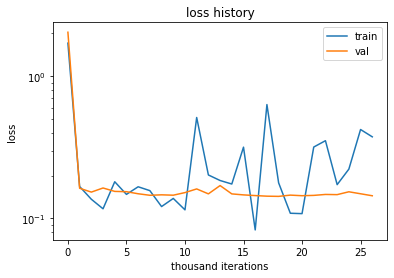

In [13]:
t_losses = [i for i in train_losses if i < 4000]
plt.plot(t_losses)
plt.plot(val_losses)
plt.title('loss history')
plt.xlabel('thousand iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.legend(['train', 'val'])

plt.show()

### Evaluate the model

In [14]:
model.eval()

pred = pred_val(X_val, model)
val_loss = criterion(pred, y_val).item()

print("Final model evaluation: ", val_loss)

Final model evaluation:  0.15096266567707062


### One-step lag predictor
The one-step lag predictor simply outputs the last timestep in the input sequence. Our model should outperform the one-step lag predictor.

In [15]:
def one_step_lag_predictor(X):
    return X[:, -1, 0].unsqueeze(1)

p_val_naive = one_step_lag_predictor(X_val.cpu())
loss_naive = criterion(p_val_naive, y_val.cpu())

print("Loss from 1-step lag predictor:\t{}\nLoss from our model:\t\t{}".format(loss_naive, val_loss))

Loss from 1-step lag predictor:	0.14193207025527954
Loss from our model:		0.15096266567707062


### Standard deviation difference

In [16]:
# switch back to cpu for plotting
X_train = X_train.cpu()
y_train = y_train.cpu()
X_val = X_val.cpu()
y_val = y_val.cpu()
pred = pred.cpu()

# backprop components no longer needed
X_train = X_train.detach()
y_train = y_train.detach()
X_val = X_val.detach()
y_val = y_val.detach()
pred = pred.detach()

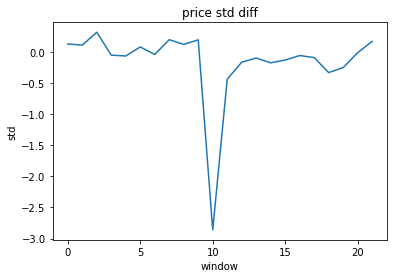

In [17]:
f1 = plt.figure()

ax1 = f1.add_subplot() 
ax1.plot((pred - y_val)[500:522])
ax1.set_title('price std diff')
ax1.set(xlabel='window', ylabel='std')

plt.show()

# plt.plot((pred[:,3] - y_val.cpu()[:,3]).detach())
# plt.title('std difference')
# plt.plot([1, 2, 3])

### Actual price difference

In [18]:
# denormalize the data
pred_abs = pred * val_std[:,0].unsqueeze(1) + val_mean[:,0].unsqueeze(1)
y_val_abs = y_val.cpu() * val_std[:,0].unsqueeze(1) + val_mean[:,0].unsqueeze(1)

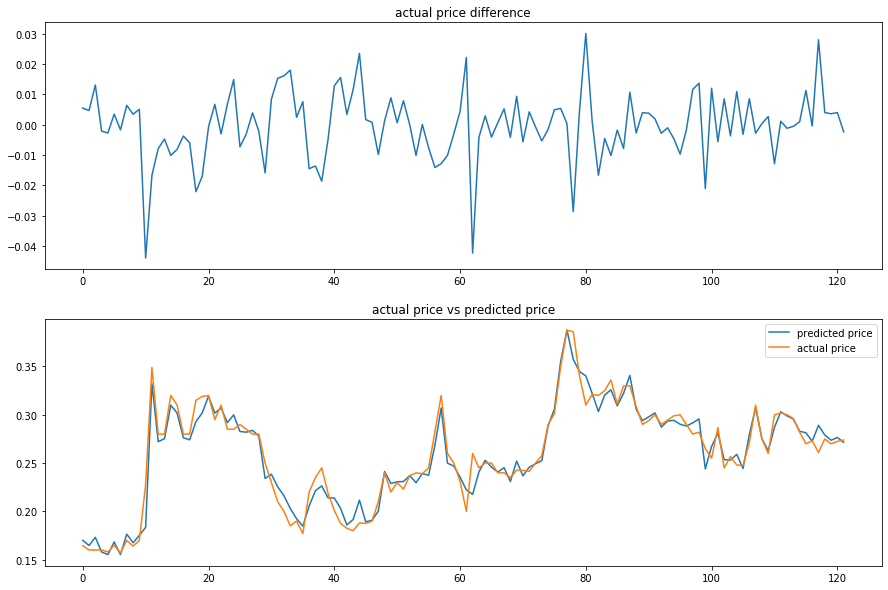

In [19]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))

ax1.set_title("actual price difference")
ax1.plot((pred_abs - y_val_abs)[500:622])

ax2.set_title("actual price vs predicted price")
l1, = ax2.plot(pred_abs[500:622])
l1.set_label("predicted price")
l2, = ax2.plot(y_val_abs[500:622])
l2.set_label("actual price")

plt.legend()
plt.show()

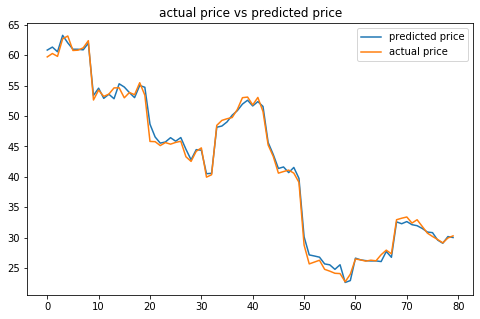

In [23]:
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.set_title("actual price vs predicted price")
l1, = ax.plot(pred_abs[300:380])
l1.set_label("predicted price")
l2, = ax.plot(y_val_abs[300:380])
l2.set_label("actual price")

plt.legend()
plt.show()